<a href="https://colab.research.google.com/github/BADS7604Group03/assignment2/blob/main/code/InceptionV3_unfreeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: Inception V3
<br>Reference: https://arxiv.org/abs/1512.00567</br>

# 1. Prepare the environment

In [1]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-e7b059b4-1d8f-54c0-0319-a50504bcb281)


In [2]:
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
import os
import cv2 as cv

import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}" )

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.experimental.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
    print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]

NumPy 1.21.5
TensorFlow 2.8.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [3]:
# Set fixed seedding values for reporoducability during experiments
# Skip this if random initialization (with varied results) is needed
np.random.seed(1234)
tf.random.set_seed(5678)

# 2. Prepare our dataset

In [4]:
#drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab Notebooks/BADS7604/Group_HW2/data"

x_image = np.load(path+"/x_image_299_299.npy" )
y_image = np.load(path+"/y_image.npy"  )
class_dict = {i:nam for i,nam in enumerate(np.load(path+"/class_seq.npy" ))}

In [5]:
num_class,num_member = np.unique(y_image, return_counts=True)
{'class':[class_dict[i] for i in num_class]
,'Image':num_member}

{'Image': array([200, 200, 200]), 'class': ['atmosphere', 'food', 'menu']}

In [6]:
# Convert data type
x_image = x_image.astype(np.uint8)
y_image = y_image.astype(np.int64)

In [7]:
# Split train set and test set
x_train, x_test, y_train, y_test = train_test_split(x_image, y_image, test_size=0.2, random_state=42, stratify=y_image, shuffle=True)

In [8]:
print(f"x_train: type={type(x_train)}, dtype={x_train.dtype}, shape={x_train.shape}, min={x_train.min(axis=None)}, max={x_train.max(axis=None)}")
print(f"y_train: type={type(y_train)}, dtype={y_train.dtype}, shape={y_train.shape}, min={min(y_train)}, max={max(y_train)}")
print(f"x_test: type={type(x_test)}, dtype={x_test.dtype}, shape={x_test.shape}, min={x_test.min(axis=None)}, max={x_test.max(axis=None)}")
print(f"y_test: type={type(y_test)}, dtype={y_test.dtype}, shape={y_test.shape}, min={min(y_test)}, max={max(y_test)}")

x_train: type=<class 'numpy.ndarray'>, dtype=uint8, shape=(480, 299, 299, 3), min=0, max=255
y_train: type=<class 'numpy.ndarray'>, dtype=int64, shape=(480,), min=0, max=2
x_test: type=<class 'numpy.ndarray'>, dtype=uint8, shape=(120, 299, 299, 3), min=0, max=255
y_test: type=<class 'numpy.ndarray'>, dtype=int64, shape=(120,), min=0, max=2


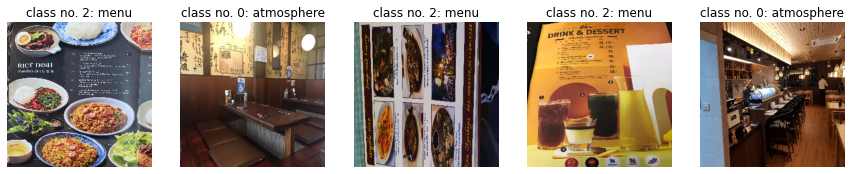

In [9]:
# Visualize the first five images in x_train
plt.figure(figsize=(15, 5))
for i in range(5):
  plt.subplot(150 + 1 + i).set_title(f"class no. {y_train[i]}: {class_dict[y_train[i]]}")
  plt.imshow(x_train[i])
  plt.axis("off")
plt.show()

In [10]:
# Build preprocess layer to match Inception V3's requirements
x_train_incep = tf.keras.applications.inception_v3.preprocess_input(x_train)
x_test_incep = tf.keras.applications.inception_v3.preprocess_input(x_test)

# 3. Load the pretrained model (only the feature extractor)

In [11]:
# Load the ImageNet Inception V3 model, ***excluding*** the latter part regarding the classifier
# Default of input shape is 299x299x3 for Inception V3
img_w, img_h = 299, 299
incep_extractor = tf.keras.applications.inception_v3.InceptionV3(weights= "imagenet", include_top=False, input_shape=(img_w, img_h, 3))

incep_extractor.summary()

87924736/87910968 [==============================] - 2s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

# 4. Prepare for transfer learning and finetuning
- Add the new classification head
- Decide wheather to freeze or unfreeze any pretrained layers

## 4.1 Access and freeze layer(s) in Keras's model

In [12]:
# Recursively freese all layers in the model
incep_extractor.trainable = False

for i, layer in enumerate(incep_extractor.layers):
  print(f"Layer {i}: name = {layer.name}, = trainable = {layer.trainable}")

Layer 0: name = input_1, = trainable = False
Layer 1: name = conv2d, = trainable = False
Layer 2: name = batch_normalization, = trainable = False
Layer 3: name = activation, = trainable = False
Layer 4: name = conv2d_1, = trainable = False
Layer 5: name = batch_normalization_1, = trainable = False
Layer 6: name = activation_1, = trainable = False
Layer 7: name = conv2d_2, = trainable = False
Layer 8: name = batch_normalization_2, = trainable = False
Layer 9: name = activation_2, = trainable = False
Layer 10: name = max_pooling2d, = trainable = False
Layer 11: name = conv2d_3, = trainable = False
Layer 12: name = batch_normalization_3, = trainable = False
Layer 13: name = activation_3, = trainable = False
Layer 14: name = conv2d_4, = trainable = False
Layer 15: name = batch_normalization_4, = trainable = False
Layer 16: name = activation_4, = trainable = False
Layer 17: name = max_pooling2d_1, = trainable = False
Layer 18: name = conv2d_8, = trainable = False
Layer 19: name = batch_norm

In [13]:
fine_tune_at = 299
for layer in incep_extractor.layers[fine_tune_at:]:
  layer.trainable = True
for i, layer in enumerate(incep_extractor.layers):
  print(f"Layer {i}: name = {layer.name}, = trainable = {layer.trainable}")

Layer 0: name = input_1, = trainable = False
Layer 1: name = conv2d, = trainable = False
Layer 2: name = batch_normalization, = trainable = False
Layer 3: name = activation, = trainable = False
Layer 4: name = conv2d_1, = trainable = False
Layer 5: name = batch_normalization_1, = trainable = False
Layer 6: name = activation_1, = trainable = False
Layer 7: name = conv2d_2, = trainable = False
Layer 8: name = batch_normalization_2, = trainable = False
Layer 9: name = activation_2, = trainable = False
Layer 10: name = max_pooling2d, = trainable = False
Layer 11: name = conv2d_3, = trainable = False
Layer 12: name = batch_normalization_3, = trainable = False
Layer 13: name = activation_3, = trainable = False
Layer 14: name = conv2d_4, = trainable = False
Layer 15: name = batch_normalization_4, = trainable = False
Layer 16: name = activation_4, = trainable = False
Layer 17: name = max_pooling2d_1, = trainable = False
Layer 18: name = conv2d_8, = trainable = False
Layer 19: name = batch_norm

## 4.2 Add a new classification head

In [14]:
x = incep_extractor.output

# Add our custom layer(s) to the end of the existing model
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dense(512 ,activation='relu')(x)
x = tf.keras.layers.Dense(256 ,activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

# Construct the main model
model = tf.keras.models.Model(inputs=incep_extractor.input, outputs=new_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

# 5. Train the model with transfer learning
No finetuning is done in this example as all pretrained layers are freezed and only newly added layers are trained.

In [15]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

In [16]:
# Create the image data generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)
train_datagen.fit(x_train_incep)

In [17]:
checkpoint_filepath = "bestmodel_epoch{epoch:02d}_valloss{val_loss:.2f}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor="val_acc", mode="max", save_best_only=True)

In [18]:
history = model.fit(train_datagen.flow(x_train_incep, y_train, batch_size=128, subset="training"),
                    epochs=50, verbose=1,
                    validation_data=train_datagen.flow(x_train_incep, y_train, subset="validation"),
                    callbacks=[model_checkpoint_callback])

Epoch 1/50
3/3 [==============================] - 24s 4s/step - loss: 15.6263 - acc: 0.3411 - val_loss: 17.9905 - val_acc: 0.2917
Epoch 2/50
3/3 [==============================] - 10s 4s/step - loss: 16.8442 - acc: 0.4401 - val_loss: 1.8152 - val_acc: 0.8333
Epoch 3/50
3/3 [==============================] - 10s 4s/step - loss: 8.3484 - acc: 0.6875 - val_loss: 2.7886 - val_acc: 0.8958
Epoch 4/50
3/3 [==============================] - 10s 4s/step - loss: 3.3147 - acc: 0.8464 - val_loss: 1.3513 - val_acc: 0.9375
Epoch 5/50
3/3 [==============================] - 10s 4s/step - loss: 1.3577 - acc: 0.9271 - val_loss: 0.3552 - val_acc: 0.9792
Epoch 6/50
3/3 [==============================] - 9s 3s/step - loss: 0.9969 - acc: 0.9349 - val_loss: 1.3266 - val_acc: 0.9271
Epoch 7/50
3/3 [==============================] - 8s 3s/step - loss: 0.6265 - acc: 0.9583 - val_loss: 0.8034 - val_acc: 0.9479
Epoch 8/50
3/3 [==============================] - 9s 3s/step - loss: 0.6686 - acc: 0.9479 - val_loss: 0

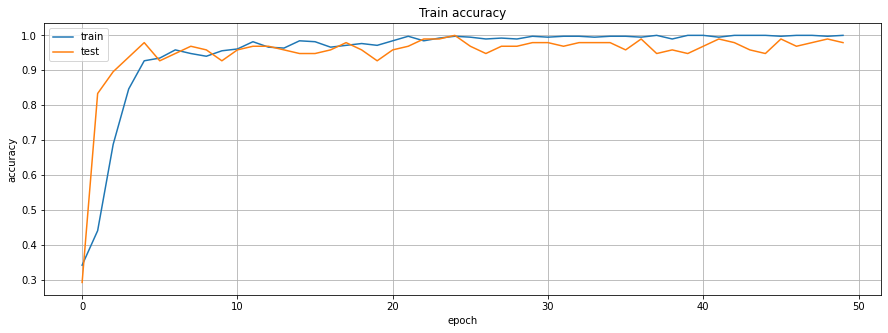

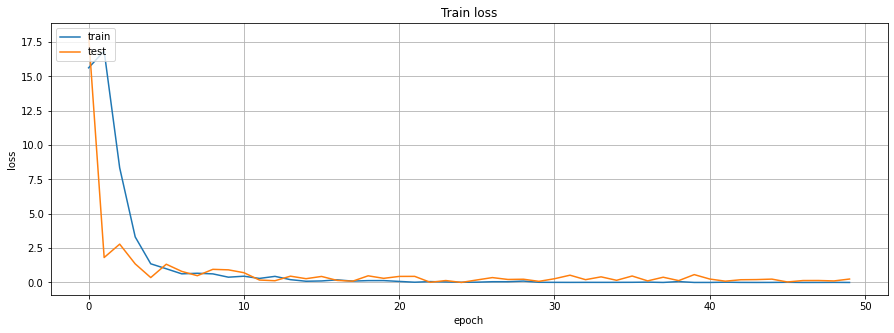

In [19]:
# Summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Train accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15, 5))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Train loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

In [20]:
#Get model best loss from file
best_loss = [x for x in sorted(os.listdir(), reverse=True) if x.startswith('bestmodel')][0]
print(best_loss)

bestmodel_epoch25_valloss0.00.hdf5


In [21]:
#Save file best model to google drive
from_path = f"/content/{best_loss}"
to_path = f"/content/drive/MyDrive/Colab Notebooks/BADS7604/Group_HW2/model/inception_v3_{best_loss}"
print(f"from : {from_path}")
print(f"to : {to_path}")
os.system(f"cp '{from_path}' '{to_path}'")

from : /content/bestmodel_epoch25_valloss0.00.hdf5
to : /content/drive/MyDrive/Colab Notebooks/BADS7604/Group_HW2/model/inception_v3_bestmodel_epoch25_valloss0.00.hdf5


0

In [22]:
# Load Best Model from file
best_model = tf.keras.models.load_model(to_path, compile=True)
print(f"Model from file : {best_loss}")
print(f"model input shape : {best_model.layers[0].get_output_at(0).get_shape()}")
print(f"Total Layer in Model : {len(best_model.layers)} \nTotal Parameter : {best_model.count_params():,.0f}")
print(f"Total Training Layer : {np.sum([layer.trainable for layer in best_model.layers])}")
print(f"Total Train Parameter : {np.sum([l.count_params() for l in best_model.layers if l.trainable == True]):,.0f}")

Model from file : bestmodel_epoch25_valloss0.00.hdf5
model input shape : (None, 299, 299, 3)
Total Layer in Model : 317 
Total Parameter : 55,621,155
Total Training Layer : 19
Total Train Parameter : 34,213,123


# 6. Evaluate the model on test set

In [23]:
# Evaluate the trained model on the test set
results = best_model.evaluate(x_test_incep, y_test, batch_size=128)
print(f"{best_model.metrics_names}: {results}")

1/1 [==============================] - 3s 3s/step - loss: 0.3124 - acc: 0.9667
['loss', 'acc']: [0.3123721182346344, 0.9666666388511658]


In [24]:
def confusionPlot(model ,x,y_true,classSeq):
  y_pred = np.argmax(model.predict(x), axis=1)
  cf_matrix = confusion_matrix(y_true, y_pred)

  ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
  ax.set_title('Confusion Matrix\n')
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values')

  ax.xaxis.set_ticklabels(classSeq)
  ax.yaxis.set_ticklabels(classSeq)
  plt.show()
  return cf_matrix

def roc_auc(model,x_feature,y_true,classSeq):
  y_prob = model.predict(x_feature)
  y_label = LabelBinarizer().fit_transform(y_test)
  class_auc = []
  plt.figure(figsize=(15,5))
  for c,nam in enumerate(classSeq):
    fpr, tpr, thresholds = roc_curve(y_label[:,c], y_prob[:,c])
    class_auc.append(auc(fpr, tpr))
    plt.plot(fpr, tpr, label = f"{nam} (AUC:{class_auc[c]:0.4f})")
  
  roc_score = roc_auc_score(y_label, y_prob, average="macro")
  plt.legend()
  plt.title(f"ROC = {roc_score:0.4f}")
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.show()
  return roc_score,class_auc

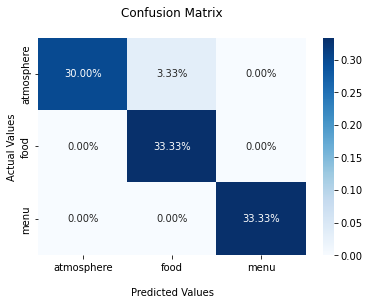

atmosphere : 0.9
food : 1.0
menu : 1.0
Total Accuracy : 0.9666666666666667


In [25]:
cf_matrix = confusionPlot(best_model, x_test_incep, y_test, class_dict.values())
for i in range(3):
  print(f"{class_dict[i]} : {cf_matrix[i,i]/cf_matrix[i,:].sum()}")
print(f"Total Accuracy : {cf_matrix.diagonal().sum()/cf_matrix.sum()}")

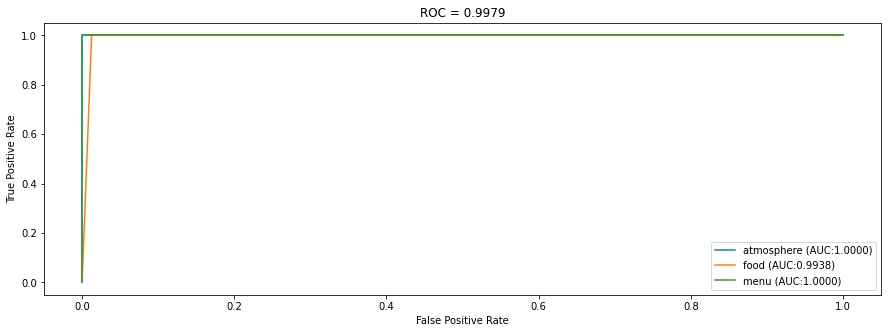

roc_score : 0.9979166666666667
atmosphere : 1.0
food : 0.99375
menu : 1.0


In [26]:
roc_score,lst_auc = roc_auc(best_model,x_test_incep,y_test, class_dict.values())
print(f"roc_score : {roc_score}")
for i in range(3):
  print(f"{class_dict[i]} : {lst_auc[i]}")

In [27]:
# Classification Report
predict = best_model.predict(x_test_incep)
predict_ = np.argmax(predict, axis=-1)
print(f"Classification Report\n{classification_report(y_test, predict_)}")

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        40
           1       0.91      1.00      0.95        40
           2       1.00      1.00      1.00        40

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



# 7. Inference

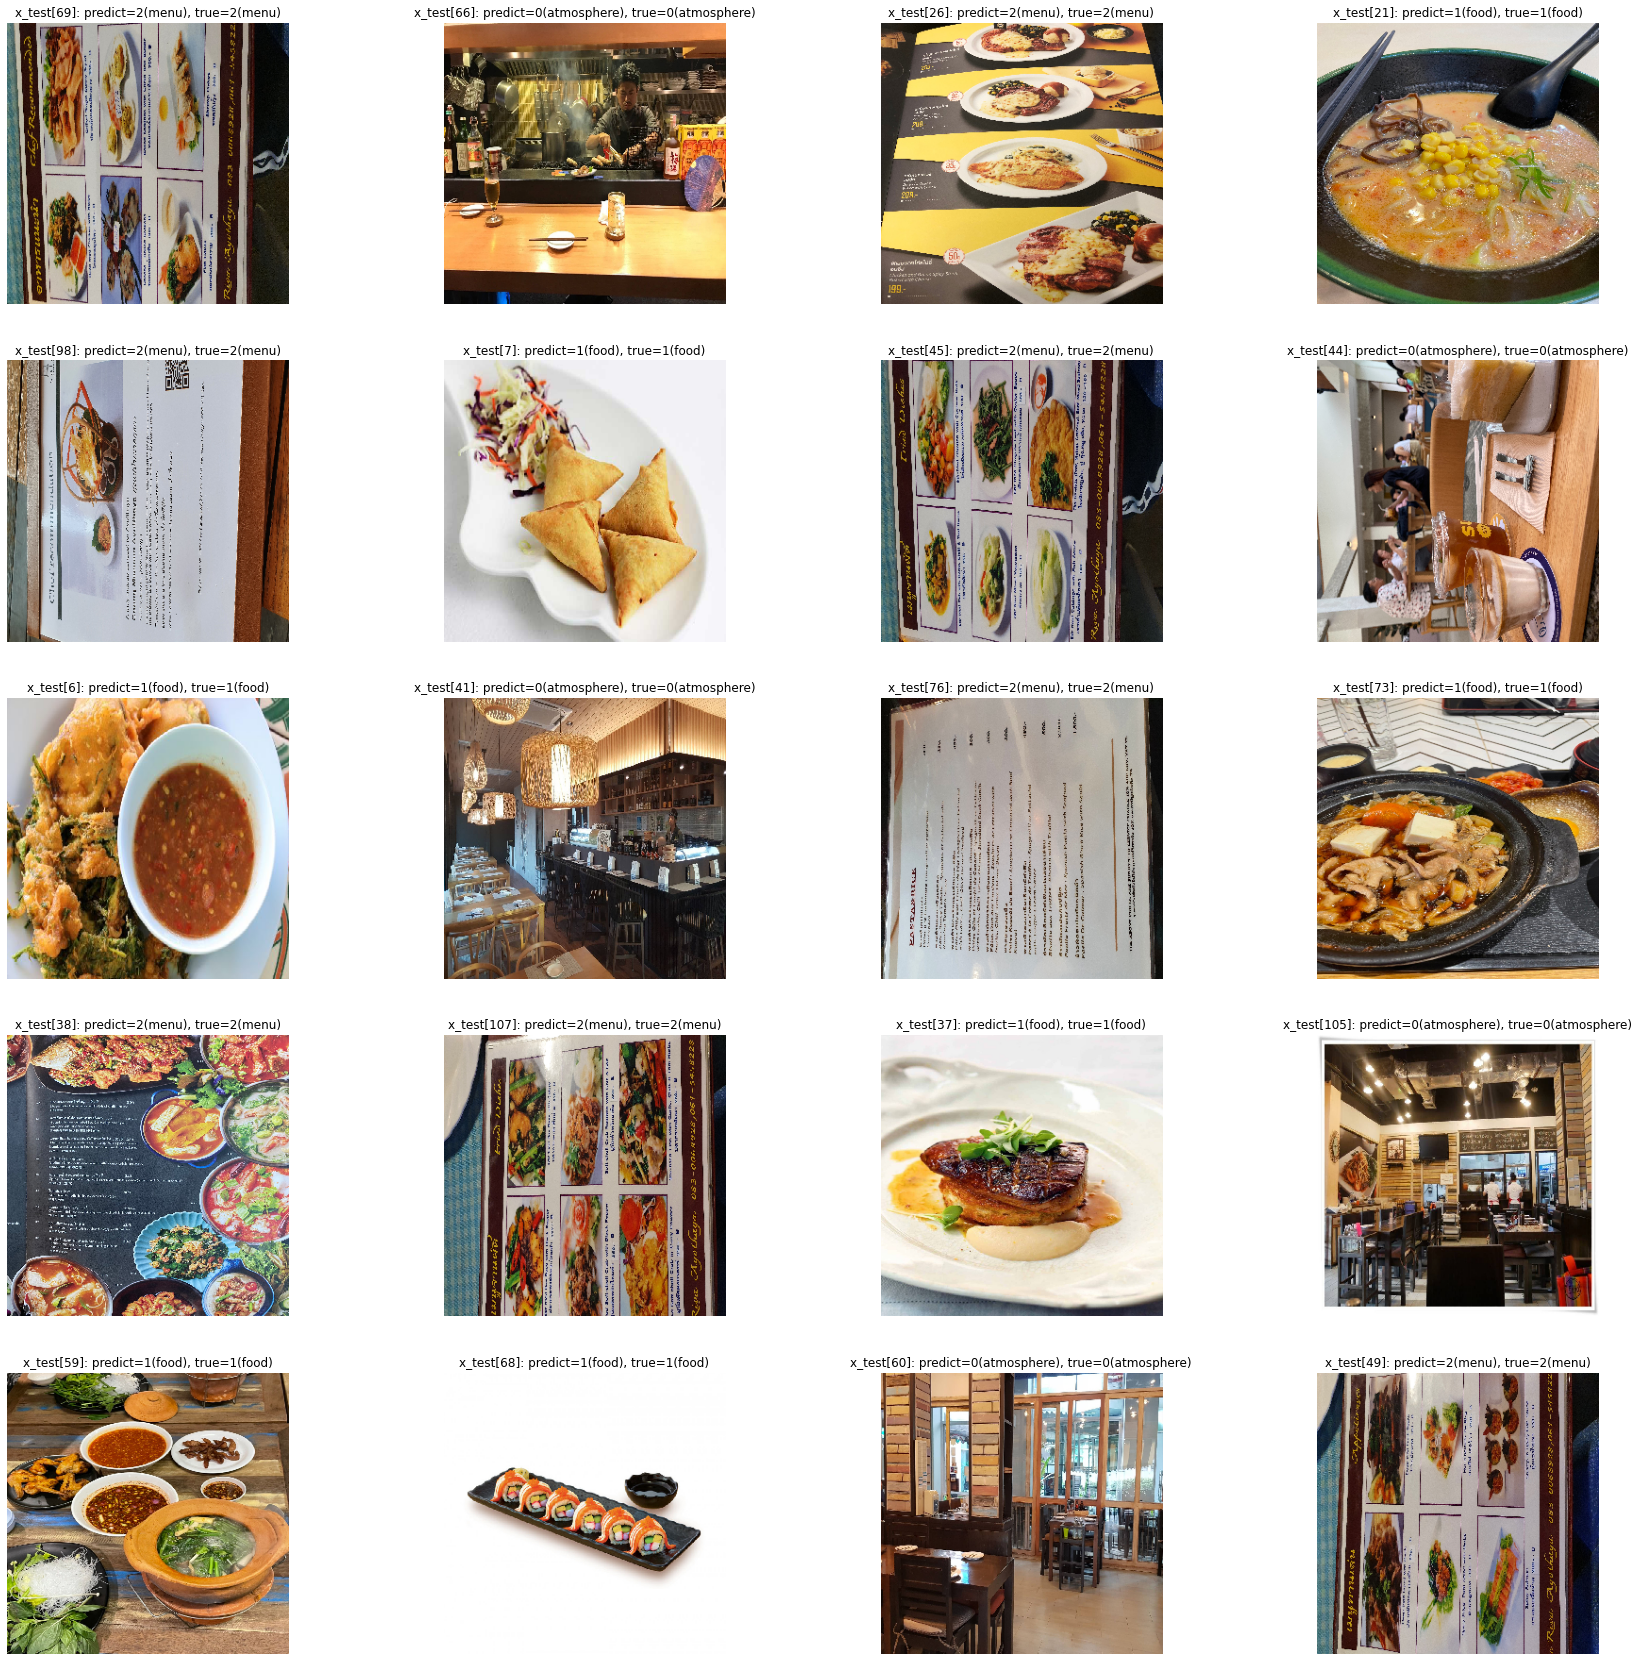

In [28]:
# Test using the model on the 20 images in x_test
plt.figure(figsize=(30, 30))
for i,j in enumerate(np.random.choice(x_test_incep.shape[0], 20, replace=False)):
  y_pred = best_model.predict(x_test_incep[j].reshape(1,img_w,img_h,3))
  
  ax = plt.subplot(5, 4, i+1)
  plt.imshow(x_test[j])
  plt.title(f"x_test[{j}]: predict={np.argmax(y_pred)}({class_dict[np.argmax(y_pred)]}), true={y_test[j]}({class_dict[int(y_test[j])]})")
  plt.axis("off")

# 8. Debug Model

## 8.1 Fix Output Layer and Get weight in Last Convolutional Layer

In [29]:
def alter_model_for_GradCAM(model, last_conv_layer_name):
  #1) Get the output from the last convolutional layer
  last_conv_output = model.get_layer(last_conv_layer_name).output

  #2) Separate the original output layer into one prediction layer and one activation softmax layer
  ### 2.1) Copy weight of the original output layers
  old_weights = [x.numpy() for x in model.layers[-1].weights]
  ### 2.2) Copy configuration of the original layer and change where necessary
  new_config = model.layers[-1].get_config()
  new_config['activation'] = tf.keras.activations.linear    #layer's activation changed
  new_config['name'] = 'pred_linear'                           #layer's name changed
  ### 2.3 Create two new layers (linear prediction and softmax)
  out_linear = tf.keras.layers.Dense(**new_config)(model.layers[-2].output)
  out_softmax = tf.keras.activations.softmax(out_linear)

  #3) Create the new model and assign the weight for the 'prediction_linear' layer
  new_model = tf.keras.Model(inputs=model.inputs, outputs=[out_softmax, out_linear, last_conv_output])
  new_model.layers[-2].set_weights(old_weights) # Assign old weight pred_linear layer 

  return new_model

In [30]:
new_model = alter_model_for_GradCAM(best_model, 'mixed10')

print(f"model input shape : {new_model.layers[0].get_output_at(0).get_shape()}")
print(f"Total Layer in Model : {len(new_model.layers)}")
print(f"Total Training Layer : {np.sum([layer.trainable for layer in new_model.layers])}")
print(f"Input layer : {new_model.input_names}")
print(f"Output layer: {new_model.output_names}")

model input shape : (None, 299, 299, 3)
Total Layer in Model : 318
Total Training Layer : 20
Input layer : ['input_1']
Output layer: ['tf.nn.softmax', 'pred_linear', 'mixed10']


In [31]:
#Test Prediction 
img_index = np.random.choice(x_test_incep.shape[0], 1)
img_test = x_test_incep[img_index].reshape(-1, img_w, img_h, 3)
img_test_ori = x_test[img_index][0]
out_softmax,out_liner,_ = new_model.predict(img_test)

## 8.2 Decode Predictions

In [32]:
def decode_prediction(preds,classDict,top_class=3):
  if preds.shape[1] != len(classDict):
    raise ValueError("Predictino and Class dict doesn't match")
  results = []
  indexs = []
  for pred in preds:
    top_indices = pred.argsort()[-top_class:][::-1]
    result = [ (i,) + (classDict[i],)+ (pred[i],) for i in top_indices]
    result.sort(key=lambda x: x[-1], reverse=True)
    indexs.append([tp[0] for tp in result ])
    results.append(result)

  return results, indexs

In [33]:
tops = 3
result_decodes,result_indexs = decode_prediction(out_softmax, class_dict, tops)
print(f"Result of decode \n {result_decodes}")
print(f"Result of index \n {result_indexs}")

Result of decode 
 [[(2, 'menu', 1.0), (1, 'food', 0.0), (0, 'atmosphere', 0.0)]]
Result of index 
 [[2, 1, 0]]


## 8.3 GradCAM Heatmap

In [34]:
def CNN_GradCAM(model,x_input,c):
  in_img = tf.cast(x_input ,tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(in_img)
    y_softmax, y_linear, last_conv_activation = model(in_img)
    one_class_score = y_linear[...,c]
  gradient = tape.gradient( one_class_score, last_conv_activation) 
  
  gradient = gradient.numpy().squeeze(axis=0)
  alpha = np.mean(gradient ,axis=(0,1)) 
  last_conv_activation = last_conv_activation.numpy().squeeze(axis=0)
  heatmap = np.dot(last_conv_activation,alpha)
  heatmap = np.maximum(0 ,heatmap)

  return heatmap

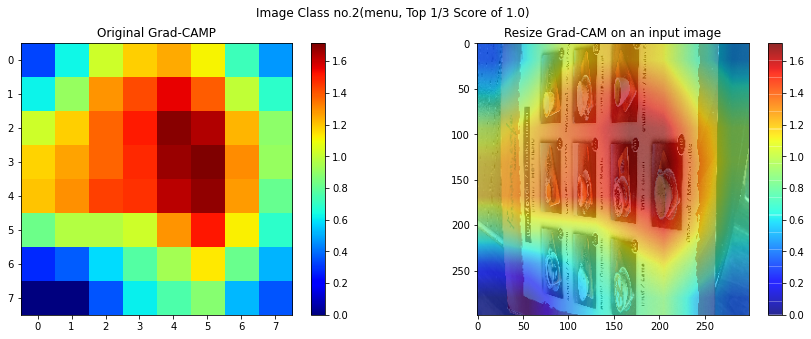

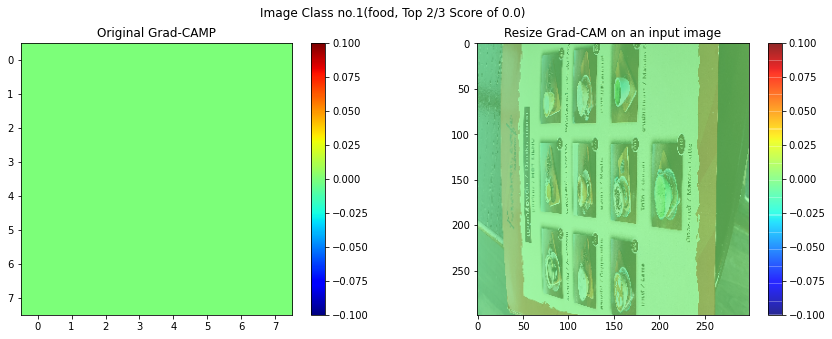

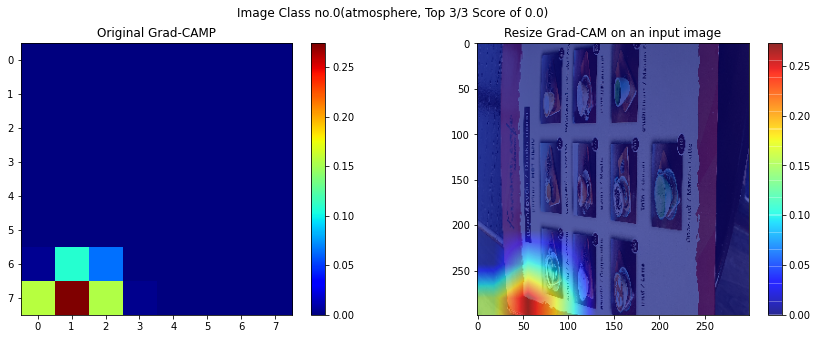

In [35]:
for i,c in enumerate(result_indexs[0]):
  heatmap = CNN_GradCAM(new_model,  img_test, c )
  #Create the main figure
  fig = plt.figure(figsize=(15,5))
  class_desc = f"{class_dict[c]}, Top {i+1}/{tops} Score of {out_softmax[...,c].squeeze()}"
  fig.suptitle(f"Image Class no.{c}({class_desc})")
  # Visualize the Original Heatmap
  ax = fig.add_subplot(1,2,1)
  ax.set_title('Original Grad-CAMP')
  im = ax.imshow( heatmap ,cmap='jet')
  plt.colorbar(im, ax=ax)

  #Visualize the heatmap overlaid on an input image
  ax = fig.add_subplot(1,2,2)
  ax.set_title('Resize Grad-CAM on an input image')
  ax.imshow(img_test_ori.astype(np.uint8))
  alpha = 0.6
  im = ax.imshow(cv.resize( heatmap, img_test_ori.shape[:2]), cmap='jet', alpha=alpha )
  plt.colorbar(im, ax=ax)

  plt.show()

## 8.4 Debug max prob in each class

In [36]:
out_softmax,out_liner,_ = new_model.predict(x_test_incep)
idx_mx_prob = []
for i in range(0,out_softmax.shape[1]):
  idx_mx_prob.append(np.argmax(out_softmax[:,i]))
print(idx_mx_prob)

[0, 2, 3]


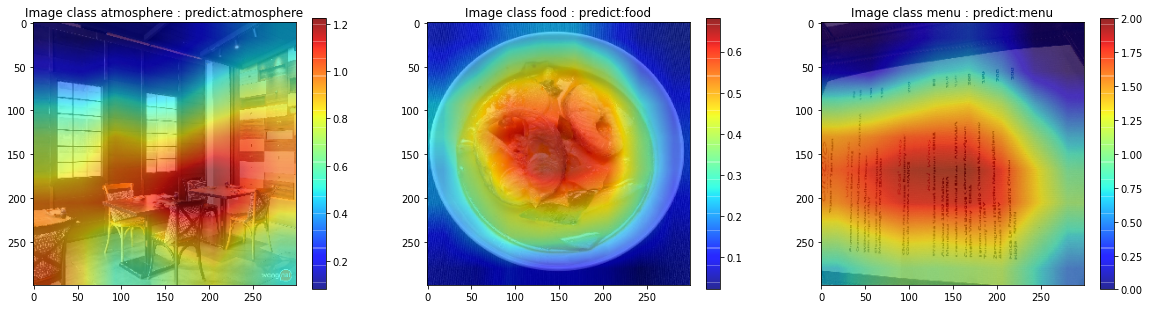

In [38]:
fig = plt.figure( figsize=(20,5))
for c,idx in enumerate(idx_mx_prob):
  img_mx_input = x_test_incep[idx].reshape(-1,299, 299, 3)
  img_mx_origi = x_test[idx]
  true_class = int(y_test[idx])
  mx_softmax,mx_liner,_ = new_model.predict(img_mx_input)
  mx_decodes,mx_indexs = decode_prediction(mx_softmax, class_dict, 1)
  predict_class = mx_indexs[0][0]

  mx_heatmap = CNN_GradCAM(new_model, img_mx_input, predict_class )

  #Create the main figure
  ax = fig.add_subplot(1, 3, c+1)
  ax.set_title(f"Image class {class_dict[true_class]} : predict:{class_dict[predict_class]}")
  ax.imshow(img_mx_origi.astype(np.uint8))
  im = ax.imshow(cv.resize( mx_heatmap, img_mx_origi.shape[:2]), cmap='jet', alpha=0.6 )
  plt.colorbar(im, ax=ax)

plt.show()